In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.notebook import tqdm
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
import torchvision
from torch.optim import Adam
from sklearn.utils import class_weight
from sklearn.metrics import precision_score, confusion_matrix, ConfusionMatrixDisplay
import sys

In [2]:
# Connect to the GPU if one exists.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using: ", device)
torch.cuda.empty_cache()

Using:  cuda


In [3]:
train_img_data = np.load(r"C:\Users\kaanan\Desktop\Noses\train_images.npy", allow_pickle = True)
train_bb_data = np.load(r"C:\Users\kaanan\Desktop\Noses\train_bb_data.npy", allow_pickle = True)
val_img_data  = np.load(r"C:\Users\kaanan\Desktop\Noses\val_images.npy", allow_pickle = True)
val_bb_data = np.load(r"C:\Users\kaanan\Desktop\Noses\val_bb_data.npy", allow_pickle = True)
test_img_data  = np.load(r"C:\Users\kaanan\Desktop\Noses\test_images.npy", allow_pickle = True)
test_bb_data = np.load(r"C:\Users\kaanan\Desktop\Noses\test_bb_data.npy", allow_pickle = True)

In [4]:
class SealDataset(Dataset):
    def __init__(self, images, labels, transform=transforms.Compose([transforms.ToTensor()])):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        self.length = len(self.labels)
        return self.length

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if label == 0:
            ret_label = torch.FloatTensor([1, 0])
        else:
            ret_label = torch.FloatTensor([0, 1])
        return self.transform(image), ret_label

In [15]:
def get_labels(bb_data, threshold):
    labels = []
    for i in range(len(bb_data)):
        if bb_data[i] is not None:
            percent = float(max(bb_data[i]["percent_seal"]))
            if percent > threshold:
                labels.append(1)
            else:
                labels.append(0)
        else:
            labels.append(0)
    return np.array(labels)

def evaluate_model(model, loader, device=device):
    model.eval()
    total_yhat = np.array([])
    total_labels = np.array([])
    for data, label in tqdm(loader):
        data = data.to(device)
        yhat = model(data).cpu().detach().numpy()
        total_yhat = np.concatenate((total_yhat, np.argmax(yhat, axis = 1)))
        total_labels = np.concatenate((total_labels, np.argmax(label.detach().numpy(), axis = 1)))
    cm_train = confusion_matrix(total_labels, total_yhat)
    ConfusionMatrixDisplay(confusion_matrix=cm_train).plot()
    tn = cm_train[0][0]
    tp = cm_train[1][1]
    fn = cm_train[1][0]
    fp = cm_train[0][1]

    precision = tp / (fp + tp)
    recall = tp / (fn + tp)
    print("Accuracy:", (tn + tp) / (tn + tp + fn + fp))
    print("Precision:", precision)
    print("Recall:", recall)

In [10]:
threshold = .3
training_labels = get_labels(train_bb_data, threshold)
val_labels = get_labels(val_bb_data, threshold)
test_labels = get_labels(test_bb_data, threshold)

In [17]:
train_labels = torch.tensor(training_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)
train_data = SealDataset(train_img_data, training_labels)
valid_data = SealDataset(val_img_data, val_labels)
test_data = SealDataset(test_img_data, test_labels)
train_loader = DataLoader(dataset = train_data, batch_size=10, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=50, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=50, shuffle=True)

C:\Users\kaanan\AppData\Local\Temp\ipykernel_26012\3109665350.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels = torch.tensor(val_labels, dtype=torch.long)
C:\Users\kaanan\AppData\Local\Temp\ipykernel_26012\3109665350.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels, dtype=torch.long)


In [13]:
efficientnet = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)
efficientnet.classifier[1] = nn.Linear(in_features=1280, out_features=2)
efficientnet.load_state_dict(torch.load(r"C:\Users\kaanan\Desktop\Noses\Pytorch Image Classifiers\ImageClassifierPytorch9"))
efficientnet = efficientnet.to(device)

  0%|          | 0/7950 [00:00<?, ?it/s]

Accuracy: 0.994251572327044
Precision: 0.9695600475624256
Recall: 0.9759425493716337


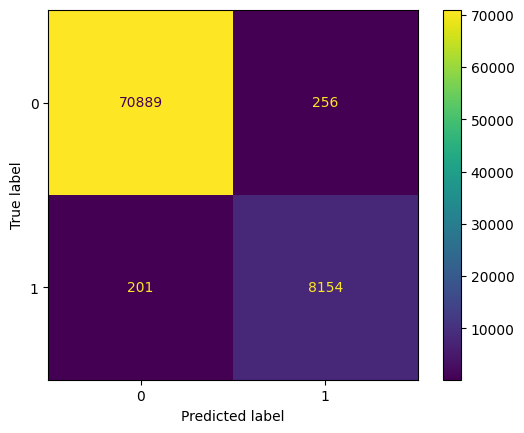

In [16]:
evaluate_model(efficientnet, train_loader, device)

  0%|          | 0/414 [00:00<?, ?it/s]

Accuracy: 0.9639090469279149
Precision: 0.8426178418387222
Recall: 0.8634730538922155


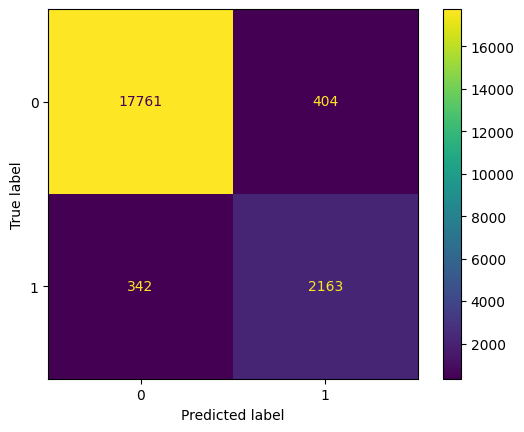

In [18]:
evaluate_model(efficientnet, valid_loader, device)

  0%|          | 0/509 [00:00<?, ?it/s]

Accuracy: 0.9687106918238994
Precision: 0.8512569832402235
Recall: 0.8682336182336182


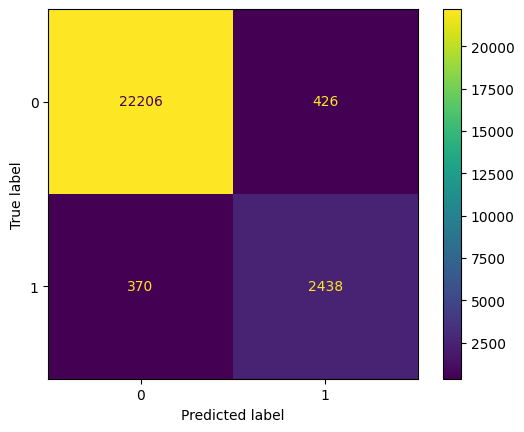

In [19]:
evaluate_model(efficientnet, test_loader, device)